In [1]:
from google.colab import drive

# drive.mount("/content/gdrive", force_remount=True)
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# Install SimpleITK
!pip install SimpleITK

     |████████████████████████████████| 44.9MB 96kB/s 


In [3]:
import os

saliencies_and_segmentations_v2_path = "/content/gdrive/My Drive/saliencies_and_segmentations_v2"

def get_path_to_saliencies_and_segmentations(sub_path):
  return os.path.join(saliencies_and_segmentations_v2_path, sub_path)

In [4]:
import numpy as np

np.random.uniform(0)

0.4414907762291602

In [5]:
import os
import math

import sklearn
import numpy as np
import SimpleITK as sitk

from keras.utils import Sequence

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from skimage.transform import resize


def process_image(path, input_shape, resize_img, normalization):
    x = sitk.GetArrayFromImage(sitk.ReadImage(path))
    if resize_img == True:
      x = resize(x, input_shape[:3])
    if normalization is not None:
      x = normalize(x, normalization)
    return np.array(x).reshape(input_shape)

def invert_img(x):
    # [x, y, z, 1]
    return x[:, :, ::-1, :]

def normalize(x, normalization):
    desc = normalization['desc']
    if normalization['type'] != 'standardization':
      return (x - desc['min']) / (desc['max'] - desc['min'])
    return (x - desc['mean']) / desc['std']

def augment_image(x, augment):
    if augment is None:
      return x

    if 'random_swap_hemispheres' in augment:
        p = augment['random_swap_hemispheres']
        if np.random.uniform(0) < p:
          return invert_img(x)

    return x

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class MRISequence(Sequence):
    def __init__(self,path, batch_size, input_shape, class_names=['AD', 'CN'], 
                 augment=None, images=True, one_hot=True, class_weight=None,
                 normalization=None, resize_img=True):
      if one_hot == False:
        self.encoder = LabelEncoder()
        self.encoder.fit(np.array(class_names))
      else:
        self.encoder = OneHotEncoder(sparse=False)
        self.encoder.fit(np.array(class_names).reshape(-1, 1))

      self.class_weight = class_weight
      self.one_hot = one_hot
      self.input_shape = input_shape
      self.resize_img = resize_img
      self.class_names = class_names
      self.images = images
      self.augment = augment
      self.normalization = normalization

      self.batch_size = batch_size
      self.images_dirs = [os.path.join(path, key) for key in os.listdir(path)]
        
    def __len__(self):
        return math.ceil(len(self.images_dirs) / self.batch_size)
        # Uncomment for debugging (when you need a smaller subset of data and faster training time)
        # return math.ceil(9 / self.batch_size)

    def __getitem__(self, idx):
        images_dirs = self.images_dirs[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        if not len(images_dirs):
          return np.array([]).reshape(-1, input_shape), np.array([]).reshape(-1, input_shape)

        # if we disabled loading images, don't do it
        if not self.images:
          batch_x = np.array([None for image_dir in images_dirs])
        else:
          batch_x = np.array([process_image(os.path.join(image_dir, 'data.nii'), self.input_shape, self.resize_img, self.normalization) for image_dir in images_dirs])
          batch_x = np.array([augment_image(x, self.augment) for x in batch_x])

        batch_y = self.__encode(np.array([self.__readfile(os.path.join(image_dir, 'real_diagnosis.txt')) for image_dir in images_dirs]))
        
        if self.class_weight is None:
          return batch_x, batch_y
        
        batch_w = np.array([self.class_weight[y] for y in self.__decode(batch_y)])
        return batch_x, batch_y, batch_w

    def __encode(self, labels):
      if self.one_hot == True:
        labels = labels.reshape(-1, 1)
      return self.encoder.transform(labels)

    def __decode(self, labels):
      if self.one_hot == True:
          return np.argmax(labels, axis=1)
      return labels

    def __readfile(self, file_path):
        fo = open(file_path, "r")
        c = fo.readline()
        fo.close()
        return c

In [6]:
%%time

import numpy as np

from tqdm import tqdm

def get_description(norm_seq, min_samples=64):
  train_x = []  

  for index, batch in enumerate(norm_seq):
      batch_x, _ = batch                     
      for x in batch_x:
        train_x.append(x)
      if min_samples is not None and len(train_x) >= min_samples:
        break
  
  return {'mean': np.mean(train_x), 'std': np.std(train_x), 'min': np.min(train_x), 'max': np.max(train_x) }

desc = get_description(MRISequence(saliencies_and_segmentations_v2_path, 64, input_shape=(112, 112, 105, 1)), min_samples=64)
print(desc)

{'mean': -2.5626754e-05, 'std': 0.9779004, 'min': -1.3373233, 'max': 7.1972704}
CPU times: user 15.2 s, sys: 1.28 s, total: 16.4 s
Wall time: 1min 34s


(6.046389, -1.0494684, 0.99998987, 0.00044830947)

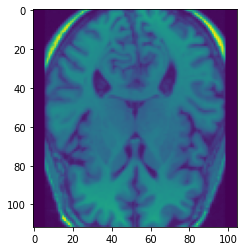

In [7]:
import matplotlib.pyplot as plt


mri_seq = MRISequence(saliencies_and_segmentations_v2_path, 4, class_weight={0: 0.4, 1: 0.6}, input_shape=(112, 112, 105, 1), normalization={'type':'standardization', 'desc':desc })

for x, y, w in mri_seq:  
  plt.imshow(x[0][56].reshape(112, 105))
  break;

x.max(), x.min(), x.std(), x.mean()

(0.86254543, 0.01609578, 0.11462103, 0.15667629)

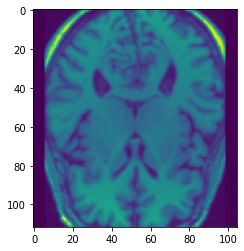

In [15]:
import matplotlib.pyplot as plt


mri_seq = MRISequence(saliencies_and_segmentations_v2_path, 16, class_weight={0: 0.4, 1: 0.6}, input_shape=(112, 112, 105, 1), normalization={'type':'normalization', 'desc':desc })

for x, y, w in mri_seq:  
  plt.imshow(x[0][56].reshape(112, 105))
  break;

x.max(), x.min(), x.std(), x.mean()

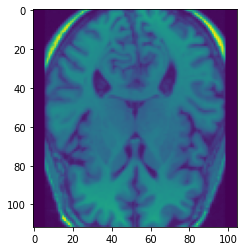

In [11]:
  plt.imshow(x[0][56].reshape(112, 105))

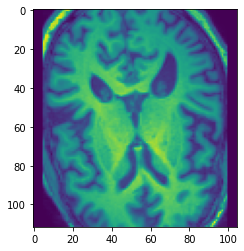

In [13]:
plt.imshow(x[1][56].reshape(112, 105))

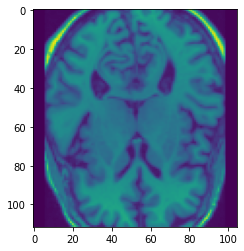

In [12]:
plt.imshow(x[2][56].reshape(112, 105))

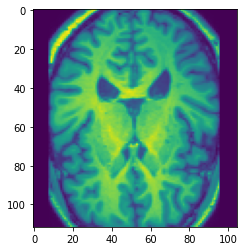

In [9]:
plt.imshow(x[3][56].reshape(112, 105))

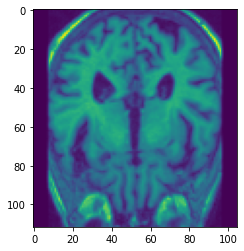

In [16]:
plt.imshow(x[4][56].reshape(112, 105))

In [ ]:
import os
import time
import shutil
import numpy as np

from tqdm import tqdm


def train_test_split(src, dst, **kwargs):
  split = kwargs.get('split', (0.8, 0.1, 0.1))
  dirname = kwargs.get('dirname', str(int(time.time())))

  if len(split) != 3:
    raise "split mus be length of three!"

  if sum(split) != 1:
    raise "sum of split must be 1!"

  dst_dir = os.path.join(dst, f'{dirname}')
  train_dir = os.path.join(dst_dir, 'train')
  test_dir = os.path.join(dst_dir, 'test')
  val_dir = os.path.join(dst_dir, 'val')
  
  if os.path.exists(dst_dir):
    print("not copying files since the destination directory already exists")

    return train_dir, test_dir, val_dir

  os.mkdir(dst_dir)
  print(f"copying to {dst_dir}...\n")

  # list of directories to copy
  src_dirs = os.listdir(src)
  print('shuffling an array...')
  np.random.shuffle(src_dirs)

  print('copying files...')
  src_dirs_count = len(src_dirs)
  for idx, dir in tqdm(enumerate(src_dirs), total=src_dirs_count):
    dst_dir = train_dir

    if idx > split[0] * src_dirs_count:
      dst_dir = test_dir
    if idx > (split[0] + split[1]) * src_dirs_count:
      dst_dir = val_dir

    shutil.copytree(os.path.join(src, dir), os.path.join(dst_dir, dir))

  return train_dir, test_dir, val_dir


# train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/')

In [ ]:
import seaborn as sns
import pandas as pd

# get paths to data
class_names=['AD', 'CN']
train_dir, test_dir, val_dir = train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/', class_names=class_names, split=(0.8, 0.15, 0.05), dirname='data-v2')

not copying files since the destination directory already exists


In [ ]:
from collections import Counter


def get_data(dir, class_names):
  seq = MRISequence(dir, 32, input_shape=(112, 112, 105, 1), images=False)
  cls = np.concatenate(np.array([np.argmax(y, axis=1) for x, y in seq]))
  return pd.DataFrame(np.array(list(map(lambda i: class_names[i], cls))), columns=['class'])

def report(df):
  count = len(df)
  counter = Counter(df['class'])

  for cls in class_names:
    print(f'{cls}: {counter[cls] / count} ({counter[cls]})')

  return sns.countplot(x='class', data=df, order=class_names)

AD: 0.6044776119402985 (243)
CN: 0.39552238805970147 (159)


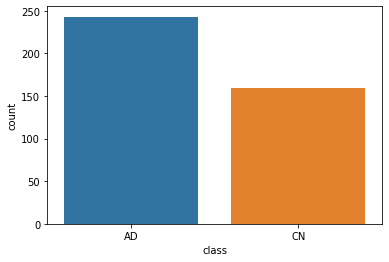

In [ ]:
df = get_data(train_dir, class_names)
report(df)

AD: 0.64 (16)
CN: 0.36 (9)


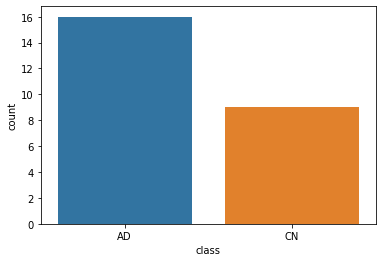

In [ ]:
df = get_data(val_dir, class_names)
report(df)

AD: 0.6933333333333334 (52)
CN: 0.30666666666666664 (23)


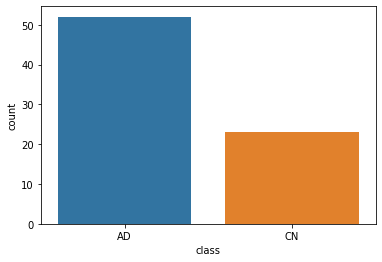

In [ ]:
df = get_data(test_dir, class_names)
report(df)

In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

AD = 243
CN = 159

# Scaling by total / 2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_ad = (1 / AD) * (AD + CN) / 2.0 
weight_for_cn = (1 / CN) * (AD + CN) / 2.0

print(f'AD: {weight_for_ad} CN: {weight_for_cn}')

AD: 0.8271604938271606 CN: 1.2641509433962266
